In [111]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, classification_report, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoderr
from skopt.space import Real, Integer, Categorical
from tqdm import tqdm
from lightgbm import LGBMClassifier
from xgboost import plot_importance

In [112]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [113]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [114]:
test.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [115]:
print(train.shape, test.shape)

(74051, 10) (49368, 9)


In [116]:
train.nunique()

id                74051
Sex                   3
Length              144
Diameter            122
Height               65
Weight             3096
Shucked Weight     1766
Viscera Weight      967
Shell Weight       1048
Age                  28
dtype: int64

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [118]:
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])
test['Sex'] = LabelEncoder().fit_transform(test['Sex'])

In [119]:
train.drop('id', axis = 1, inplace=True)
test.drop('id', axis = 1, inplace=True)

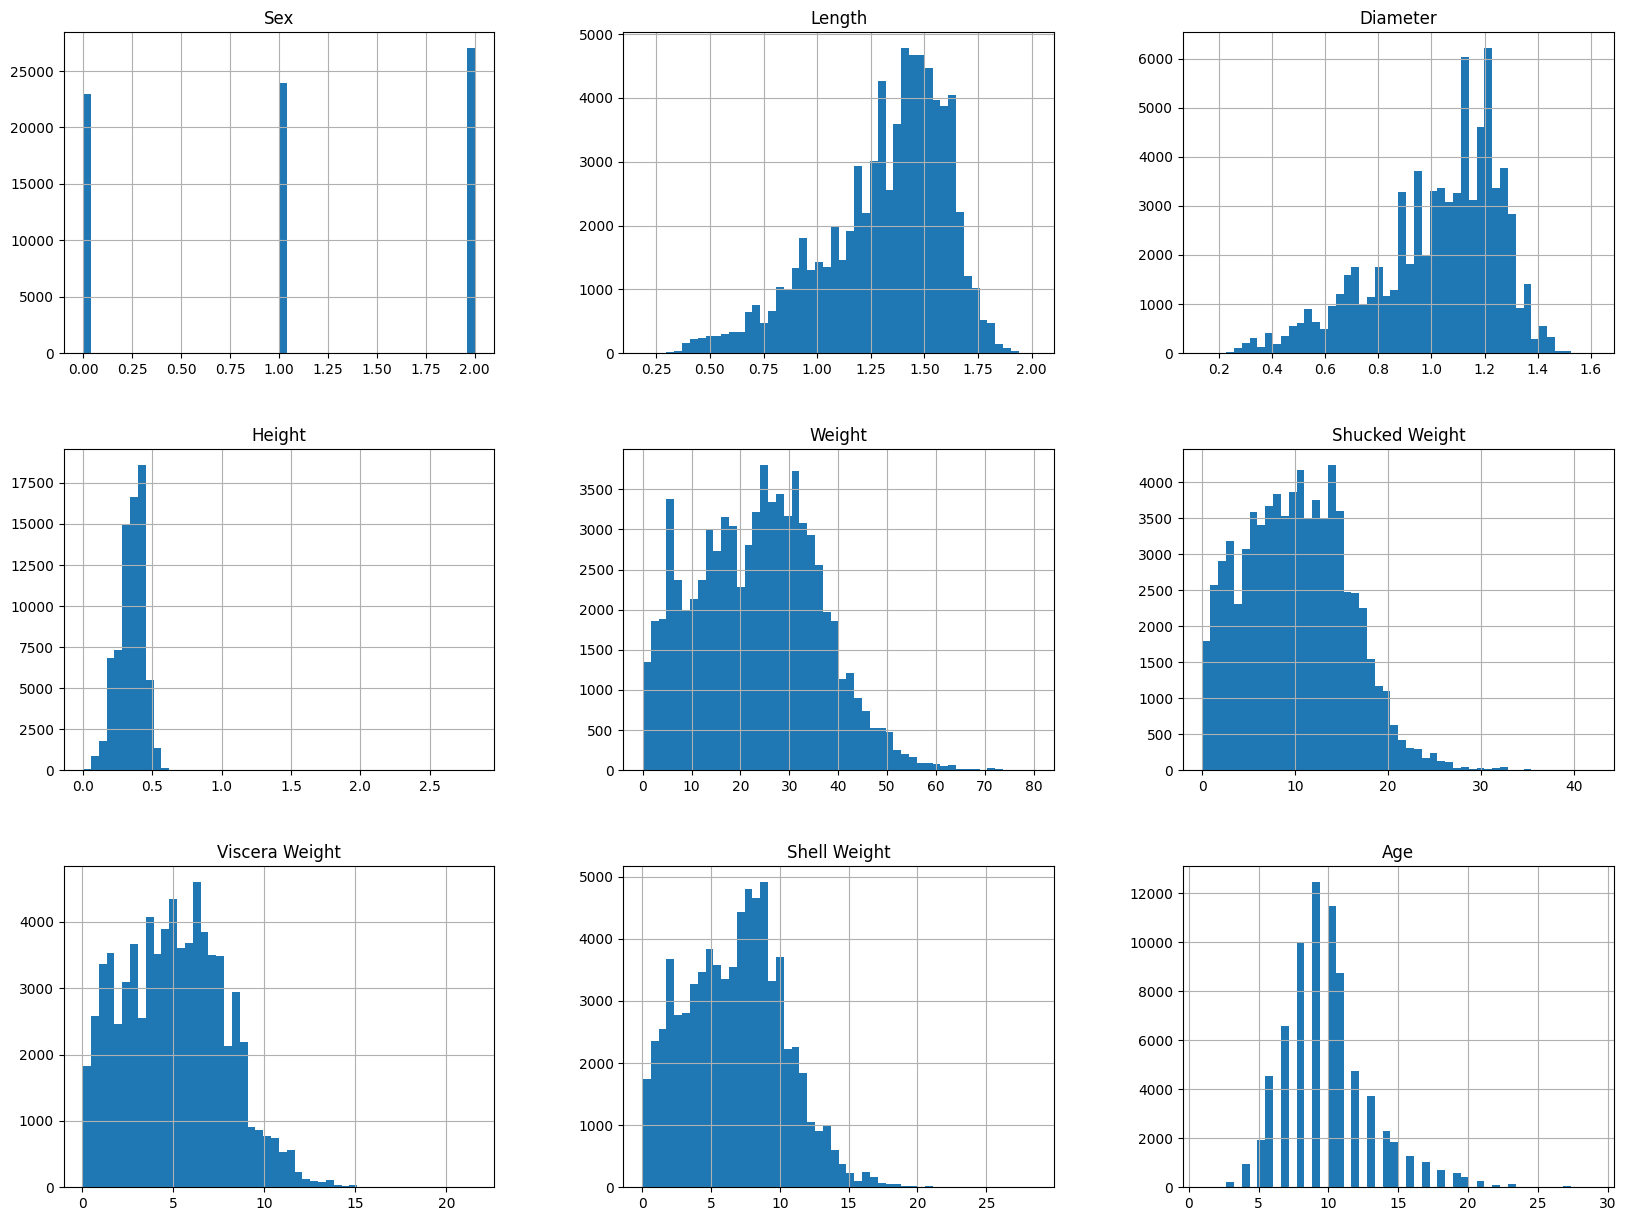

In [120]:
train.hist(bins=50, figsize=(20,15))
plt.show()

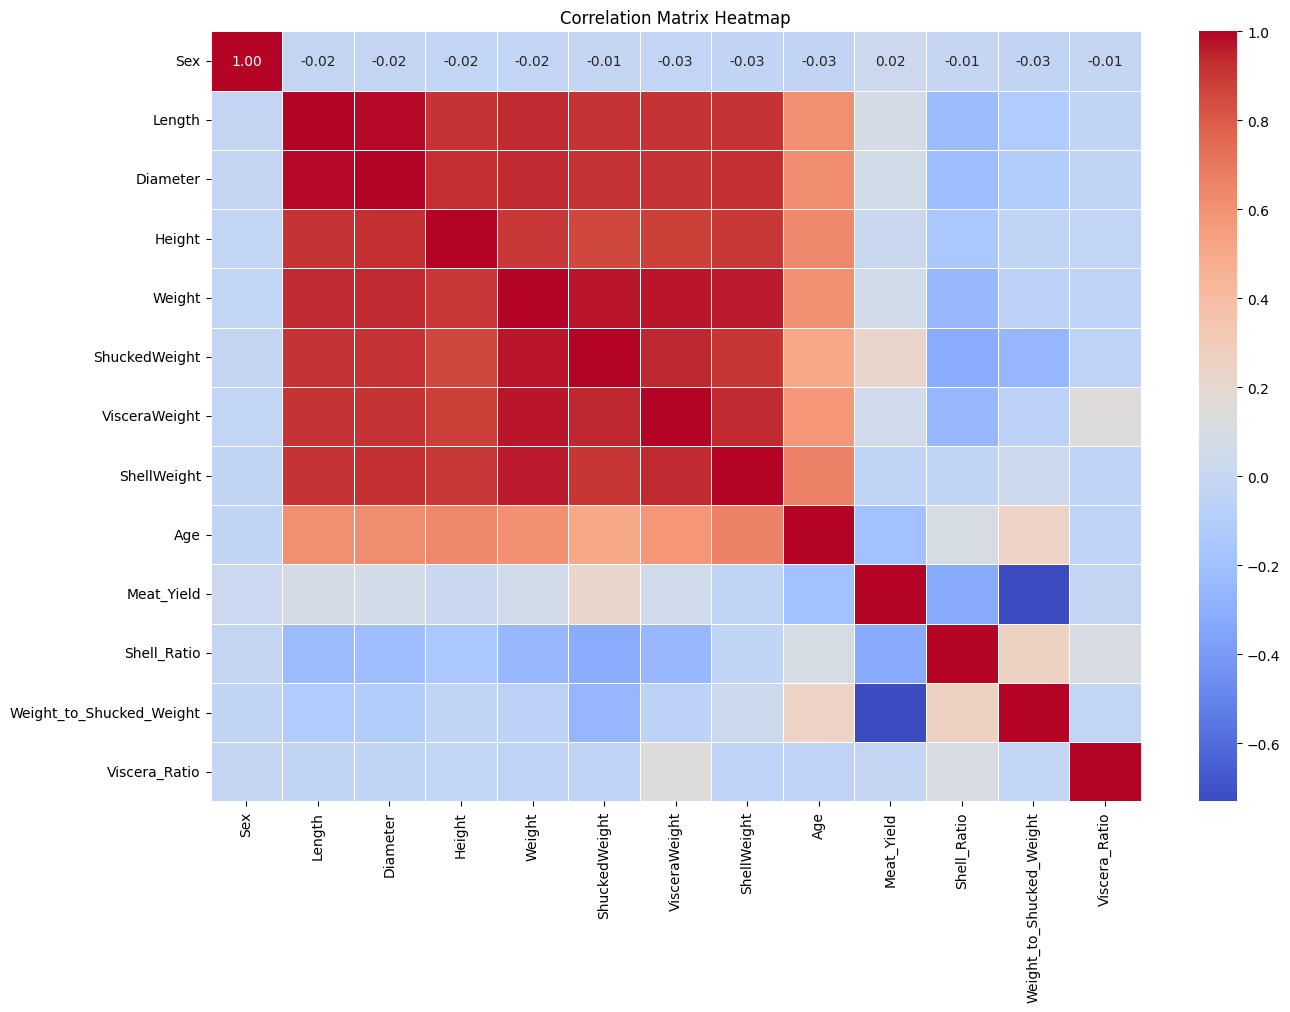

In [129]:
# Compute the correlation matrix
correlation_matrix = train.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [122]:
def new_features(df):
    df['Meat_Yield'] = df['Shucked Weight'] / (df['Weight'] + df['Shell Weight'])
    df['Shell_Ratio'] = df['Shell Weight'] / df['Weight']
    df['Weight_to_Shucked_Weight'] = df['Weight'] / df['Shucked Weight']
    df['Viscera_Ratio'] = df['Viscera Weight'] / df['Weight']
    return df
    
new_features(train)
new_features(test)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Meat_Yield,Shell_Ratio,Weight_to_Shucked_Weight,Viscera_Ratio
0,1,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,0.322500,0.315789,2.356589,0.200658
1,1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,0.360990,0.255941,2.205645,0.209324
2,0,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,0.286550,0.330739,2.622449,0.266537
3,0,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,0.377902,0.247752,2.120763,0.230769
4,1,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,0.366197,0.283133,2.128205,0.209639
...,...,...,...,...,...,...,...,...,...,...,...,...
49363,0,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309,0.333333,0.230235,2.438559,0.317116
49364,1,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687,0.321026,0.344828,2.316294,0.194483
49365,0,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345,0.283698,0.280036,2.753731,0.218157
49366,0,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163,0.295533,0.316742,2.569767,0.238009


In [123]:
# Replace spaces with nothing (i.e., remove them) in column names
train.columns = train.columns.str.replace(' ', '')
test.columns = test.columns.str.replace(' ', '')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 55538, number of used features: 12
[LightGBM] [Info] Start training from score 9.970021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 55538, number of used features: 12
[LightGBM] [Info] Start training from score 9.977853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 55538, number of used features: 12
[LightGBM] [Info] Start tra

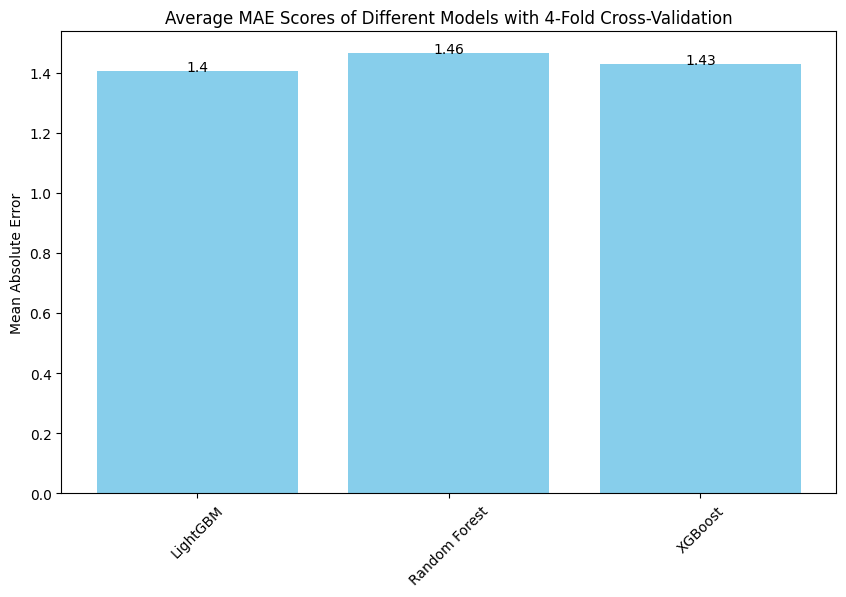

In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dictionary of models
models = {
    "LightGBM": lgb.LGBMRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
}

# Dictionary to store MAE scores for each fold
mae_scores = {name: [] for name in models.keys()}

# 10-fold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Training and evaluating each model for each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_scores[name].append(mean_absolute_error(y_test, y_pred))

# Calculating average MAE for each model
avg_mae_scores = {name: np.mean(scores) for name, scores in mae_scores.items()}

# Plotting the results with average MAE values
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(avg_mae_scores)), list(avg_mae_scores.values()), align='center', color='skyblue')
plt.xticks(range(len(avg_mae_scores)), list(avg_mae_scores.keys()), rotation=45)

# Annotate each bar with the average MAE
[plt.text(i, bar.get_height(), round(bar.get_height(), 2), ha='center') for i, bar in enumerate(bars)]

plt.title('Average MAE Scores of Different Models with 4-Fold Cross-Validation')
plt.ylabel('Mean Absolute Error')
plt.show()


In [125]:
avg_mae_scores

{'LightGBM': 1.4039937558513138,
 'Random Forest': 1.4637552636807203,
 'XGBoost': 1.4272943397055138}

In [126]:
mae_scores

{'LightGBM': [1.4084139843893684,
  1.3949342461411915,
  1.4304168910796664,
  1.3822099017950291],
 'Random Forest': [1.4637260303570463,
  1.4590736239399342,
  1.4874353157240858,
  1.4447860847018148],
 'XGBoost': [1.4312428580055243,
  1.416149052449063,
  1.457052330063349,
  1.4047331183041183]}

# Hyperparameter tuning for lgbm with hyperopt

In [132]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Assuming 'train' is your DataFrame

X = train.drop(['Age'], axis=1)
y = train['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Define the search space for hyperparameters
space = {
    'num_leaves': hp.choice('num_leaves', range(20, 41)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(100, 501)),
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# Define the objective function
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    model = lgb.LGBMRegressor(**params, verbose=-1) 
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return {'loss': mae, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best Parameters:", best)

# Train a new model with the best parameters
best['n_estimators'] = int(best['n_estimators'])
best['num_leaves'] = int(best['num_leaves'])
best['max_depth'] = int(best['max_depth'])
best_lgbm_model = lgb.LGBMRegressor(**best, verbose=-1) 
best_lgbm_model.fit(X_train, y_train)

# Making predictions with the optimized model
Y_pred_optimized = best_lgbm_model.predict(X_test)

# Calculating MAE with the optimized model
mae_optimized = mean_absolute_error(y_test, Y_pred_optimized)
print("Optimized MAE:", mae_optimized)


100%|█████████| 30/30 [00:18<00:00,  1.60trial/s, best loss: 1.4185557446950783]
Best Parameters: {'colsample_bytree': 0.6592749261051158, 'learning_rate': 0.040970269865970084, 'max_depth': 6, 'n_estimators': 286, 'num_leaves': 7, 'subsample': 0.8154801002849856}
Optimized MAE: 1.424514072862436


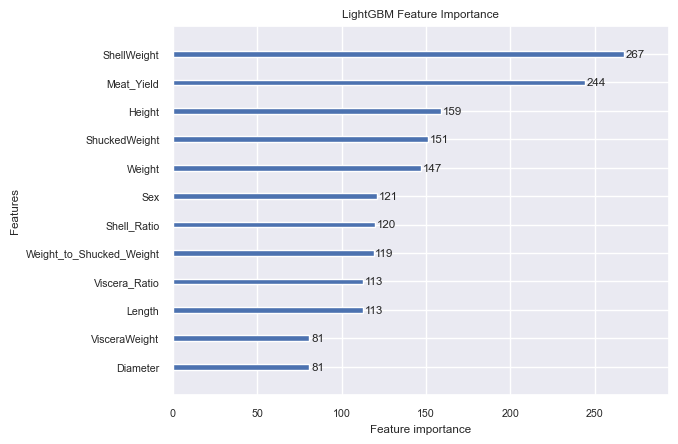

In [133]:
# Plotting feature importance
lgb.plot_importance(best_lgbm_model, max_num_features=30, importance_type='split')
plt.title('LightGBM Feature Importance')
plt.show()
